In [1]:
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor


from nirs4all.operators.transformations import Gaussian, SavitzkyGolay, StandardNormalVariate, Haar, MultiplicativeScatterCorrection
from nirs4all.operators.models.cirad_tf import nicon, customizable_nicon
from nirs4all.pipeline.config import PipelineConfigs
from nirs4all.dataset.dataset_config import DatasetConfigs
from nirs4all.pipeline.runner import PipelineRunner
import json
from sklearn.ensemble import GradientBoostingRegressor

pipeline = [
    MinMaxScaler(feature_range=(0.1, 0.8)),
    MultiplicativeScatterCorrection,
    ShuffleSplit(n_splits=3),
    {"y_processing": MinMaxScaler},
    {"model": PLSRegression(15)},
    {"model": PLSRegression(10)},
    {"model": RandomForestRegressor(n_estimators=100)},
    {"model": ElasticNet()},
    {"model": SVR(kernel='rbf', C=1.0, epsilon=0.1)},
    {"model": MLPRegressor(hidden_layer_sizes=(50,50), max_iter=500)},
    {"model": GradientBoostingRegressor(n_estimators=100)},
    {"model": nicon,
     "train_params": {
                # Final training parameters
                "epochs": 500,
                "patience": 50,
                "batch_size": 500,
                # "cyclic_lr": True,
                # "step_size": 20,
                "lr": 0.001,
                "verbose": 0  # 0=silent, 1=progress bar, 2=one line per epoch
            },
    },

]

# create pipeline config
config = PipelineConfigs(pipeline)

# path = ['../../sample_data/regression', '../../sample_data/classification', '../../sample_data/binary']
path = '../../sample_data/regression'
dataset_config_obj = DatasetConfigs(path)

# Runner setup with spinner enabled (default is True, but let's be explicit)
runner = PipelineRunner(save_binaries=False, show_spinner=True, verbose=0)
print("🔄 Running pipeline with spinner enabled - watch for loading animations during model training!")
results = runner.run(config, dataset_config_obj)

✅ Loaded pipeline(s) with 1 configuration(s).
🔄 Running pipeline with spinner enabled - watch for loading animations during model training!
📥 Loaded 177 predictions from results\regression\regression_predictions.json
🚀 Starting pipeline config_bc79abf3 on dataset regression
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
🔷 Step 1: {'class': 'sklearn.preprocessing._data.MinMaxScaler', 'params': {'feature_range': [0.1, 0.8]}, '_runtime_instance': MinMaxScaler(feature_range=(0.1, 0.8))}
🔹 Executing controller TransformerMixinController with operator MinMaxScaler
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
🔷 Step 2: nirs4all.operators.transformations.nirs.MultiplicativeScatterCorrectio

Best PLSRegression: PLSRegression (partition: test_fold_2) - RMSE: 10.083920, R²: 0.110239, MAE: 8.558707
Best RandomForestRegressor: RandomForestRegressor (partition: test_fold_2) - RMSE: 17.118922, R²: -1.564292, MAE: 13.288331
Best ElasticNet: ElasticNet (partition: test_fold_2) - RMSE: 12.450660, R²: -0.356436, MAE: 11.057028
Best SVR: SVR (partition: test_fold_2) - RMSE: 11.184856, R²: -0.094650, MAE: 10.314437
Best MLPRegressor: MLPRegressor (partition: test_fold_1) - RMSE: 15.570801, R²: 0.212066, MAE: 11.624726
Best GradientBoostingRegressor: GradientBoostingRegressor (partition: test_fold_1) - RMSE: 18.468031, R²: -0.108432, MAE: 16.018872
Best nicon: nicon (partition: test_fold_1) - RMSE: 17.239311, R²: 0.034154, MAE: 15.203960


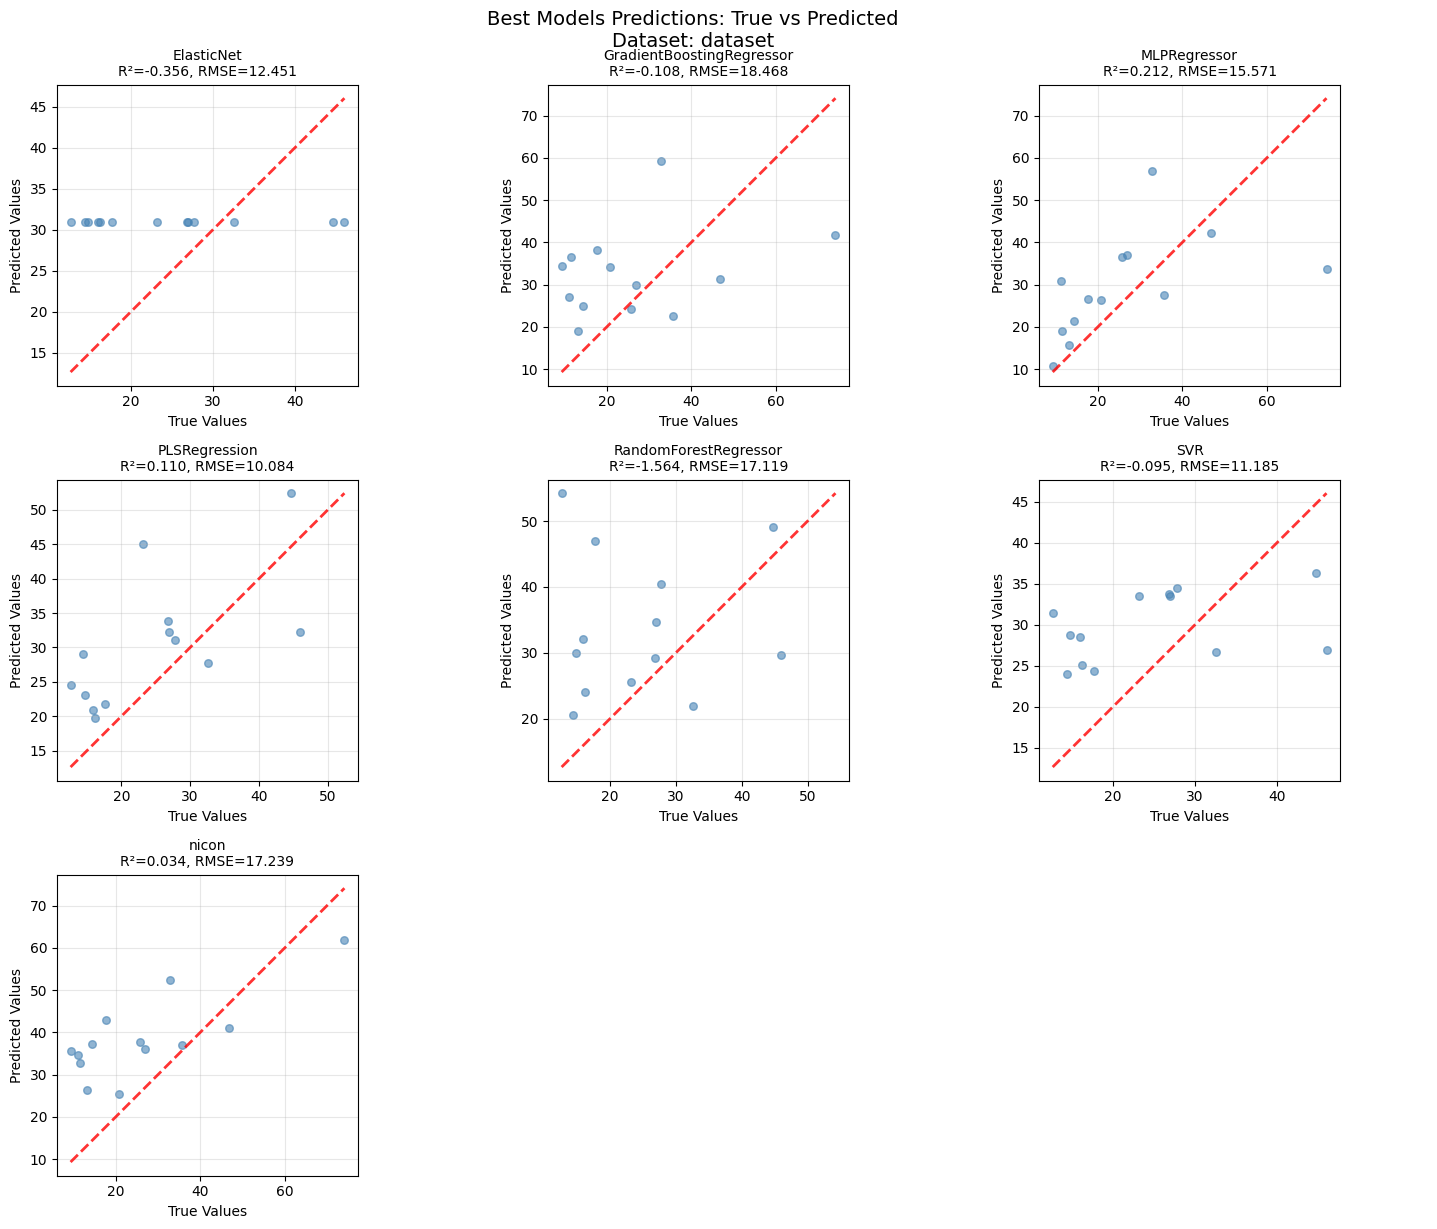

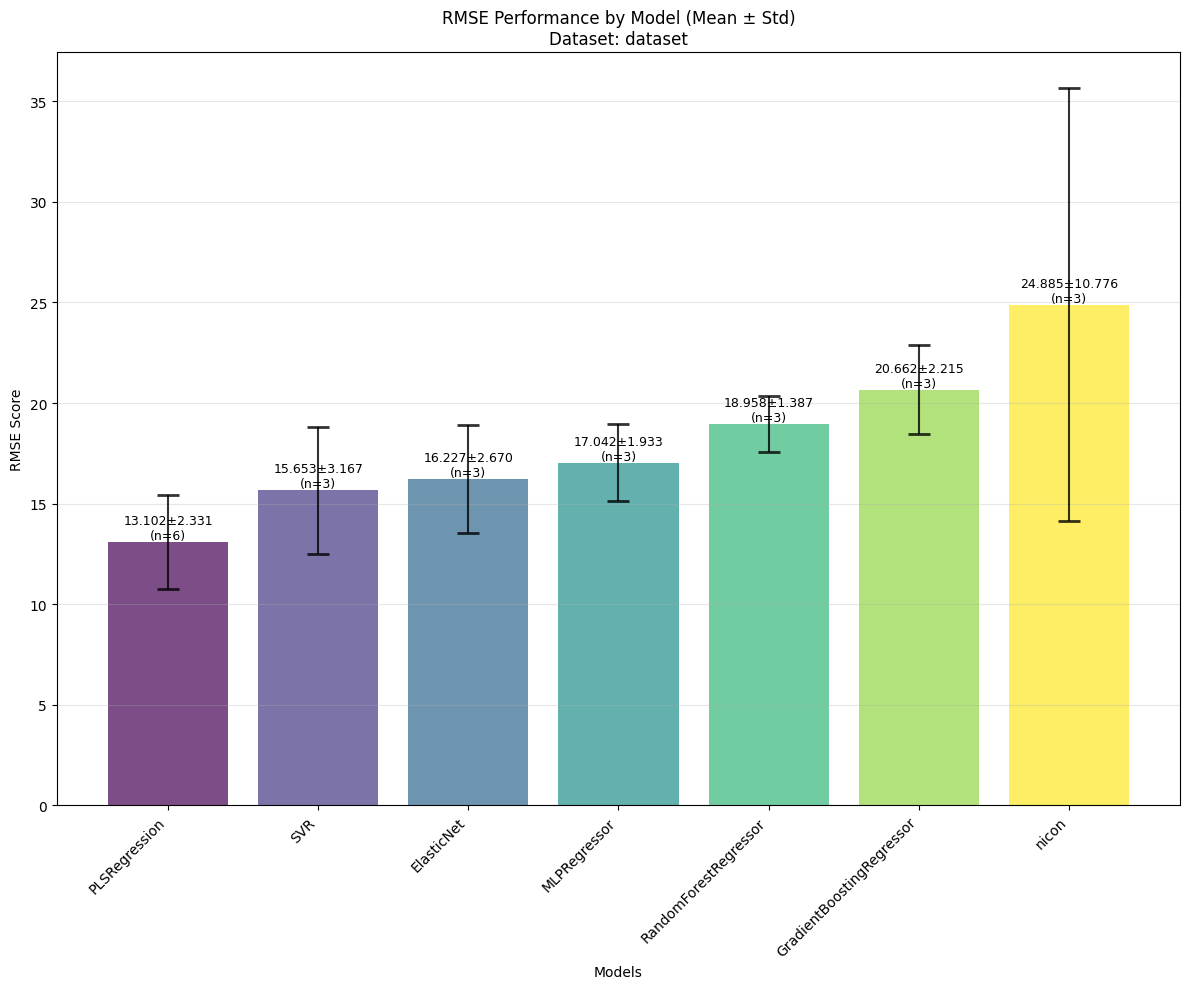

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from nirs4all.dataset.prediction_visualizer import PredictionVisualizer

global_predictions, run_predictions = results[0]
visualizer = PredictionVisualizer(run_predictions, dataset_name_override="dataset")

best = visualizer.get_best_models_by_type()
for model_type, model_info in best.items():
    print(f"Best {model_info['base_model']}: {model_type} (partition: {model_info['partition']}) - RMSE: {model_info['metrics']['rmse']:.6f}, R²: {model_info['metrics']['r2']:.6f}, MAE: {model_info['metrics']['mae']:.6f}")
fig = visualizer.plot_best_models_predictions(metric='rmse')
fig = visualizer.plot_models_performance_bars(metric='rmse')